In [1]:
import subprocess
import torch
import numpy as np
import mnist
import matplotlib.pyplot as plt
import math
import svgd
import random
%matplotlib inline
mnist.init()

def generate_sign(n = 2000, size = 28, length_min = 13, length_max = 20, width_min = 3, width_max = 5):
    center = math.floor(size / 2)
    sign = np.random.choice((-1, 1), size = n)
    length = np.random.choice(np.arange(length_min, length_max + 1), size = n)
    width = np.random.choice(np.arange(width_min, width_max + 1), size = n)
    start = np.random.choice(np.arange(4, size - length_max - 1), size = n) - center
    x = np.tile(np.arange(size), size) - center
    y = np.repeat(np.arange(size), size) - center
    
    sign_img = np.zeros((n, size**2))
    for i in range(n):
        sign_i = sign[i]
        length_i = length[i]
        width_i = width[i]
        start_i = start[i]
        minus_i = ((x >= start_i) &
                   (x <= start_i + length_i) &
                   (y >= - math.floor(width_i / 2)) &
                   (y <= - math.floor(width_i / 2) + width_i))
        if sign_i == -1:
            sign_img[i, :] = minus_i * 1
        else:
            mid_i = (length_i + 2 * start_i) / 2
            minus_i_2 = ((x >= math.floor(mid_i - width_i / 2)) &
                         (x <= math.floor(mid_i + width_i / 2)) &
                         (y >= -math.floor(length_i / 2)) &
                         (y <= -math.floor(length_i / 2) + length_i))
            sign_img[i, :] = (minus_i | minus_i_2) * 1
    
    sign_img[sign_img > 0] = 0.9 * sign_img[sign_img > 0] + np.random.normal(scale = 0.05, size = np.sum(sign_img > 0))
    return sign_img, sign


class BFNN(torch.nn.Module):
    def __init__(self, d, L, n, V):
        super().__init__()
        self.d = d
        self.L = L
        self.n = n
        self.V = V
        self.theta = torch.nn.Parameter(torch.randn(self.n, self.L))

        # define layers
        #self.num_nodes = num_nodes
        #self.layers = []
        #for i in range(len(num_nodes)):
        #  if i == 0:
        #    self.layers.append(torch.nn.Linear(self.d, num_nodes[0]))
        #  else:
        #    self.layers.append(torch.nn.Linear(num_nodes[i-1], num_nodes[i]))
        #self.layers.append(torch.nn.Linear(num_nodes[-1], L))
        self.layer1 = torch.nn.Linear(d, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, 128)
        self.layer4 = torch.nn.Linear(128, 128)
        self.layerL = torch.nn.Linear(128, L)

        # define activation functions
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        #for i in range(len(self.num_nodes)):
        #  X = self.layers[i](X)
        #  X = self.relu(X)
        #self.Psi = self.layers[-1](X)

        X = self.layer1(X)
        X = self.relu(X)
        X = self.layer2(X)
        X = self.relu(X)
        X = self.layer3(X)
        X = self.relu(X)
        X = self.layer4(X)
        X = self.relu(X)
        self.Psi = self.layerL(X)
        self.yhat = self.theta @ self.Psi.t() 
        return self.yhat
    

class Dataset(torch.utils.data.Dataset):
    def __init__(self, predictors, labels):
        self.labels = labels
        self.predictors = predictors

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        X = self.predictors[index, :]
        y = self.labels[index, :]

        return X, y
    

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.linear = nn.Linear(32 * 7 * 7, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    

import torch.nn as nn

class CNN_FB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 64, 3, 1, "same"),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size = 2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 32, 3, 1, "same"),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 32, 3, 1, "same"),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(32, 32, 3, 1, "same"),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.linear1 = nn.Linear(160, 64)
        self.linear2 = nn.Linear(64, 784)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
                                 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)      
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [2]:
train_img, train_label, test_img, test_label = mnist.load()
train_img = train_img / 255
test_img = test_img / 255

Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0642, training r2: 0.145
epoch: 2 / 30, training rmse: 0.9812, training r2: 0.2732
epoch: 3 / 30, training rmse: 0.9064, training r2: 0.3798
epoch: 4 / 30, training rmse: 0.8408, training r2: 0.4663
epoch: 5 / 30, training rmse: 0.7901, training r2: 0.5287
epoch: 6 / 30, training rmse: 0.757, training r2: 0.5673
epoch: 7 / 30, training rmse: 0.7391, training r2: 0.5876
epoch: 8 / 30, training rmse: 0.7282, training r2: 0.5996
epoch: 9 / 30, training rmse: 0.7212, training r2: 0.6073
epoch: 10 / 30, training rmse: 0.7156, training r2: 0.6135
epoch: 11 / 30, training rmse: 0.7115, training r2: 0.6179
epoch: 12 / 30, training rmse: 0.7085, training r2: 0.6211
epoch: 13 / 30, training rmse: 0.7051, training r2: 0.6246
epoch: 14 / 30, training rmse: 0.7028, training r2: 0.6271
epoch: 15 / 30, training rmse: 0.7005, training r2: 0.6296
epoch: 16 / 30, training rmse: 0.6982, training r2: 0.632
epoch: 17 / 30, training rmse: 0.6959, training r2: 0.6344
epoch: 18

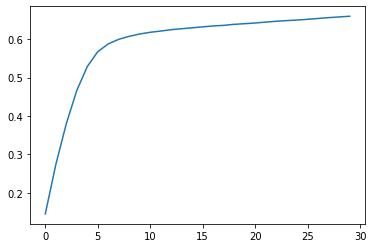

0 [1.    1.    0.989 0.996] [0.03696432 0.04464831 0.03839371 0.04655979]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0554, training r2: 0.1545
epoch: 2 / 30, training rmse: 0.9726, training r2: 0.2819
epoch: 3 / 30, training rmse: 0.8998, training r2: 0.3853
epoch: 4 / 30, training rmse: 0.8381, training r2: 0.4668
epoch: 5 / 30, training rmse: 0.792, training r2: 0.5239
epoch: 6 / 30, training rmse: 0.7621, training r2: 0.5592
epoch: 7 / 30, training rmse: 0.7451, training r2: 0.5786
epoch: 8 / 30, training rmse: 0.7334, training r2: 0.5917
epoch: 9 / 30, training rmse: 0.7248, training r2: 0.6012
epoch: 10 / 30, training rmse: 0.7179, training r2: 0.6088
epoch: 11 / 30, training rmse: 0.7125, training r2: 0.6146
epoch: 12 / 30, training rmse: 0.708, training r2: 0.6195
epoch: 13 / 30, training rmse: 0.7049, training r2: 0.6228
epoch: 14 / 30, training rmse: 0.7014, training r2: 0.6266
epoch: 15 / 30, training rmse: 0.6987, training r2: 0.6295
epoch: 16 / 30, training rmse: 0.6967, training r2: 0.6316
epoch: 17 / 30, training rmse: 0.6943, training r2: 0.6341
epoch: 1

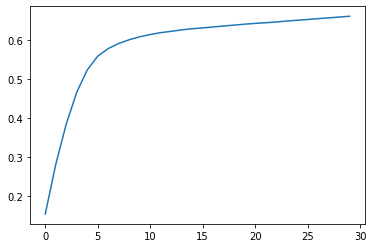

1 [1.    1.    0.994 0.997] [0.03673954 0.04385884 0.03679138 0.0475305 ]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0613, training r2: 0.1579
epoch: 2 / 30, training rmse: 0.9748, training r2: 0.2896
epoch: 3 / 30, training rmse: 0.8972, training r2: 0.3982
epoch: 4 / 30, training rmse: 0.832, training r2: 0.4825
epoch: 5 / 30, training rmse: 0.7828, training r2: 0.5419
epoch: 6 / 30, training rmse: 0.7521, training r2: 0.5772
epoch: 7 / 30, training rmse: 0.7354, training r2: 0.5957
epoch: 8 / 30, training rmse: 0.7257, training r2: 0.6063
epoch: 9 / 30, training rmse: 0.7186, training r2: 0.614
epoch: 10 / 30, training rmse: 0.7137, training r2: 0.6192
epoch: 11 / 30, training rmse: 0.7093, training r2: 0.6238
epoch: 12 / 30, training rmse: 0.7064, training r2: 0.6269
epoch: 13 / 30, training rmse: 0.703, training r2: 0.6306
epoch: 14 / 30, training rmse: 0.7003, training r2: 0.6334
epoch: 15 / 30, training rmse: 0.6979, training r2: 0.6358
epoch: 16 / 30, training rmse: 0.6957, training r2: 0.6382
epoch: 17 / 30, training rmse: 0.6937, training r2: 0.6402
epoch: 18

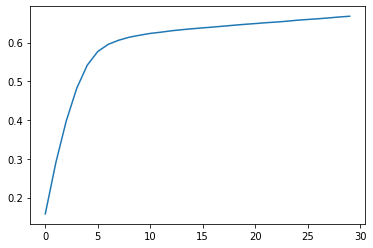

2 [1.    1.    0.995 0.998] [0.03657688 0.04538249 0.03674162 0.04916062]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0563, training r2: 0.1458
epoch: 2 / 30, training rmse: 0.9708, training r2: 0.2785
epoch: 3 / 30, training rmse: 0.8945, training r2: 0.3876
epoch: 4 / 30, training rmse: 0.8293, training r2: 0.4736
epoch: 5 / 30, training rmse: 0.7803, training r2: 0.5339
epoch: 6 / 30, training rmse: 0.7503, training r2: 0.5691
epoch: 7 / 30, training rmse: 0.7332, training r2: 0.5885
epoch: 8 / 30, training rmse: 0.7227, training r2: 0.6001
epoch: 9 / 30, training rmse: 0.7147, training r2: 0.609
epoch: 10 / 30, training rmse: 0.709, training r2: 0.6151
epoch: 11 / 30, training rmse: 0.7044, training r2: 0.6201
epoch: 12 / 30, training rmse: 0.7008, training r2: 0.624
epoch: 13 / 30, training rmse: 0.6975, training r2: 0.6276
epoch: 14 / 30, training rmse: 0.6945, training r2: 0.6307
epoch: 15 / 30, training rmse: 0.6924, training r2: 0.6331
epoch: 16 / 30, training rmse: 0.6897, training r2: 0.6358
epoch: 17 / 30, training rmse: 0.687, training r2: 0.6387
epoch: 18 

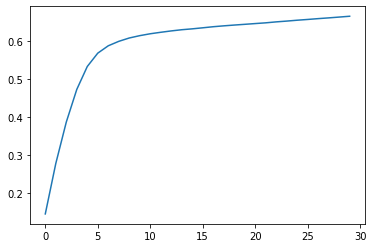

3 [1.    1.    0.992 0.998] [0.03588937 0.04430479 0.03924873 0.04592192]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0571, training r2: 0.1535
epoch: 2 / 30, training rmse: 0.9732, training r2: 0.2826
epoch: 3 / 30, training rmse: 0.8994, training r2: 0.3872
epoch: 4 / 30, training rmse: 0.8376, training r2: 0.4686
epoch: 5 / 30, training rmse: 0.7914, training r2: 0.5256
epoch: 6 / 30, training rmse: 0.7617, training r2: 0.5605
epoch: 7 / 30, training rmse: 0.7451, training r2: 0.5795
epoch: 8 / 30, training rmse: 0.7348, training r2: 0.591
epoch: 9 / 30, training rmse: 0.7273, training r2: 0.5993
epoch: 10 / 30, training rmse: 0.7216, training r2: 0.6056
epoch: 11 / 30, training rmse: 0.7171, training r2: 0.6105
epoch: 12 / 30, training rmse: 0.7133, training r2: 0.6146
epoch: 13 / 30, training rmse: 0.7104, training r2: 0.6177
epoch: 14 / 30, training rmse: 0.7073, training r2: 0.621
epoch: 15 / 30, training rmse: 0.7053, training r2: 0.6232
epoch: 16 / 30, training rmse: 0.7032, training r2: 0.6255
epoch: 17 / 30, training rmse: 0.7005, training r2: 0.6284
epoch: 1

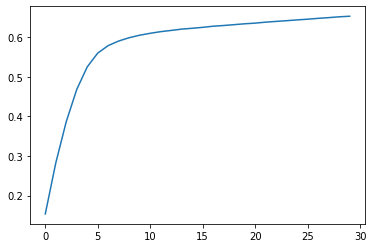

4 [1.    1.    0.992 0.999] [0.03747211 0.04502889 0.03902916 0.04670369]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0546, training r2: 0.1491
epoch: 2 / 30, training rmse: 0.9692, training r2: 0.2814
epoch: 3 / 30, training rmse: 0.8912, training r2: 0.3924
epoch: 4 / 30, training rmse: 0.8251, training r2: 0.4792
epoch: 5 / 30, training rmse: 0.7749, training r2: 0.5407
epoch: 6 / 30, training rmse: 0.744, training r2: 0.5765
epoch: 7 / 30, training rmse: 0.7273, training r2: 0.5953
epoch: 8 / 30, training rmse: 0.7174, training r2: 0.6062
epoch: 9 / 30, training rmse: 0.7108, training r2: 0.6135
epoch: 10 / 30, training rmse: 0.7057, training r2: 0.619
epoch: 11 / 30, training rmse: 0.7017, training r2: 0.6234
epoch: 12 / 30, training rmse: 0.6986, training r2: 0.6266
epoch: 13 / 30, training rmse: 0.6955, training r2: 0.63
epoch: 14 / 30, training rmse: 0.693, training r2: 0.6326
epoch: 15 / 30, training rmse: 0.6906, training r2: 0.6352
epoch: 16 / 30, training rmse: 0.6887, training r2: 0.6372
epoch: 17 / 30, training rmse: 0.6863, training r2: 0.6396
epoch: 18 /

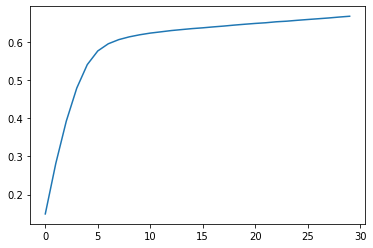

5 [1.    1.    0.992 0.994] [0.03637581 0.04505684 0.03601903 0.04891197]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0584, training r2: 0.1524
epoch: 2 / 30, training rmse: 0.9763, training r2: 0.2787
epoch: 3 / 30, training rmse: 0.9041, training r2: 0.3816
epoch: 4 / 30, training rmse: 0.8428, training r2: 0.4625
epoch: 5 / 30, training rmse: 0.796, training r2: 0.5206
epoch: 6 / 30, training rmse: 0.7652, training r2: 0.557
epoch: 7 / 30, training rmse: 0.7477, training r2: 0.577
epoch: 8 / 30, training rmse: 0.7359, training r2: 0.5903
epoch: 9 / 30, training rmse: 0.7267, training r2: 0.6005
epoch: 10 / 30, training rmse: 0.7194, training r2: 0.6084
epoch: 11 / 30, training rmse: 0.7133, training r2: 0.615
epoch: 12 / 30, training rmse: 0.7092, training r2: 0.6195
epoch: 13 / 30, training rmse: 0.705, training r2: 0.624
epoch: 14 / 30, training rmse: 0.7014, training r2: 0.6278
epoch: 15 / 30, training rmse: 0.6989, training r2: 0.6304
epoch: 16 / 30, training rmse: 0.6962, training r2: 0.6333
epoch: 17 / 30, training rmse: 0.694, training r2: 0.6356
epoch: 18 / 3

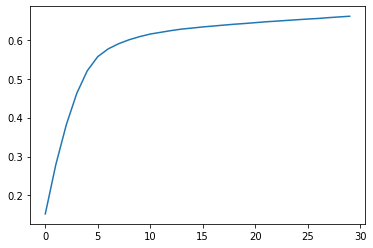

6 [1.    1.    0.995 1.   ] [0.03702606 0.04402541 0.03764444 0.04632778]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0471, training r2: 0.1591
epoch: 2 / 30, training rmse: 0.9613, training r2: 0.2913
epoch: 3 / 30, training rmse: 0.8841, training r2: 0.4006
epoch: 4 / 30, training rmse: 0.8184, training r2: 0.4864
epoch: 5 / 30, training rmse: 0.7688, training r2: 0.5467
epoch: 6 / 30, training rmse: 0.738, training r2: 0.5823
epoch: 7 / 30, training rmse: 0.7215, training r2: 0.6008
epoch: 8 / 30, training rmse: 0.711, training r2: 0.6123
epoch: 9 / 30, training rmse: 0.704, training r2: 0.6199
epoch: 10 / 30, training rmse: 0.6986, training r2: 0.6257
epoch: 11 / 30, training rmse: 0.695, training r2: 0.6295
epoch: 12 / 30, training rmse: 0.6914, training r2: 0.6334
epoch: 13 / 30, training rmse: 0.6886, training r2: 0.6364
epoch: 14 / 30, training rmse: 0.6864, training r2: 0.6387
epoch: 15 / 30, training rmse: 0.684, training r2: 0.6412
epoch: 16 / 30, training rmse: 0.682, training r2: 0.6433
epoch: 17 / 30, training rmse: 0.6799, training r2: 0.6455
epoch: 18 / 

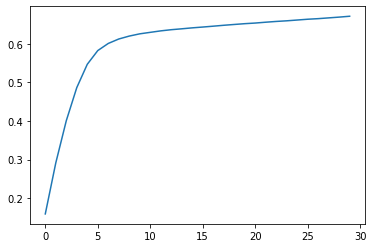

7 [1. 1. 1. 1.] [0.03551371 0.04318775 0.03747423 0.04548248]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0639, training r2: 0.1504
epoch: 2 / 30, training rmse: 0.9797, training r2: 0.2796
epoch: 3 / 30, training rmse: 0.9031, training r2: 0.3879
epoch: 4 / 30, training rmse: 0.8382, training r2: 0.4727
epoch: 5 / 30, training rmse: 0.7885, training r2: 0.5333
epoch: 6 / 30, training rmse: 0.7564, training r2: 0.5706
epoch: 7 / 30, training rmse: 0.7384, training r2: 0.5908
epoch: 8 / 30, training rmse: 0.7279, training r2: 0.6023
epoch: 9 / 30, training rmse: 0.7201, training r2: 0.6108
epoch: 10 / 30, training rmse: 0.715, training r2: 0.6163
epoch: 11 / 30, training rmse: 0.7105, training r2: 0.6211
epoch: 12 / 30, training rmse: 0.7077, training r2: 0.624
epoch: 13 / 30, training rmse: 0.7044, training r2: 0.6276
epoch: 14 / 30, training rmse: 0.702, training r2: 0.6301
epoch: 15 / 30, training rmse: 0.6998, training r2: 0.6325
epoch: 16 / 30, training rmse: 0.6974, training r2: 0.6349
epoch: 17 / 30, training rmse: 0.6952, training r2: 0.6373
epoch: 18

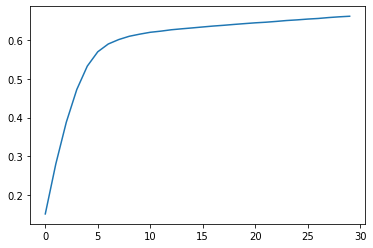

8 [1.    1.    1.    0.999] [0.03685891 0.04294361 0.03435116 0.04709223]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0448, training r2: 0.1451
epoch: 2 / 30, training rmse: 0.9625, training r2: 0.2745
epoch: 3 / 30, training rmse: 0.8894, training r2: 0.3805
epoch: 4 / 30, training rmse: 0.8272, training r2: 0.4642
epoch: 5 / 30, training rmse: 0.7794, training r2: 0.5243
epoch: 6 / 30, training rmse: 0.7483, training r2: 0.5614
epoch: 7 / 30, training rmse: 0.7297, training r2: 0.583
epoch: 8 / 30, training rmse: 0.7179, training r2: 0.5964
epoch: 9 / 30, training rmse: 0.7094, training r2: 0.6059
epoch: 10 / 30, training rmse: 0.7026, training r2: 0.6134
epoch: 11 / 30, training rmse: 0.6971, training r2: 0.6195
epoch: 12 / 30, training rmse: 0.6932, training r2: 0.6237
epoch: 13 / 30, training rmse: 0.6896, training r2: 0.6276
epoch: 14 / 30, training rmse: 0.6868, training r2: 0.6306
epoch: 15 / 30, training rmse: 0.6845, training r2: 0.6331
epoch: 16 / 30, training rmse: 0.6822, training r2: 0.6355
epoch: 17 / 30, training rmse: 0.6803, training r2: 0.6375
epoch: 

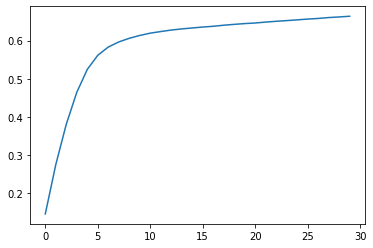

9 [1.    1.    0.998 1.   ] [0.03618347 0.04488383 0.03909908 0.04572347]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0607, training r2: 0.1397
epoch: 2 / 30, training rmse: 0.9773, training r2: 0.2697
epoch: 3 / 30, training rmse: 0.9014, training r2: 0.3788
epoch: 4 / 30, training rmse: 0.8355, training r2: 0.4663
epoch: 5 / 30, training rmse: 0.7856, training r2: 0.5281
epoch: 6 / 30, training rmse: 0.7552, training r2: 0.5639
epoch: 7 / 30, training rmse: 0.7389, training r2: 0.5825
epoch: 8 / 30, training rmse: 0.7299, training r2: 0.5926
epoch: 9 / 30, training rmse: 0.7238, training r2: 0.5994
epoch: 10 / 30, training rmse: 0.7193, training r2: 0.6044
epoch: 11 / 30, training rmse: 0.7156, training r2: 0.6085
epoch: 12 / 30, training rmse: 0.7125, training r2: 0.6118
epoch: 13 / 30, training rmse: 0.7101, training r2: 0.6145
epoch: 14 / 30, training rmse: 0.7075, training r2: 0.6172
epoch: 15 / 30, training rmse: 0.7057, training r2: 0.6192
epoch: 16 / 30, training rmse: 0.7036, training r2: 0.6215
epoch: 17 / 30, training rmse: 0.7011, training r2: 0.6242
epoch:

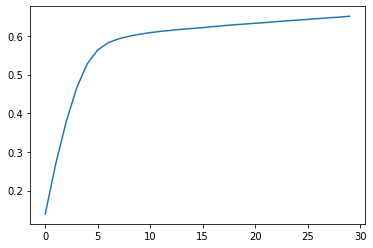

10 [1.    1.    0.982 0.983] [0.03782741 0.04384433 0.04083516 0.04603567]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0518, training r2: 0.1441
epoch: 2 / 30, training rmse: 0.9694, training r2: 0.2729
epoch: 3 / 30, training rmse: 0.8933, training r2: 0.3826
epoch: 4 / 30, training rmse: 0.8284, training r2: 0.4691
epoch: 5 / 30, training rmse: 0.7796, training r2: 0.5297
epoch: 6 / 30, training rmse: 0.7484, training r2: 0.5666
epoch: 7 / 30, training rmse: 0.7308, training r2: 0.5868
epoch: 8 / 30, training rmse: 0.7212, training r2: 0.5976
epoch: 9 / 30, training rmse: 0.7137, training r2: 0.6059
epoch: 10 / 30, training rmse: 0.708, training r2: 0.6122
epoch: 11 / 30, training rmse: 0.7037, training r2: 0.6168
epoch: 12 / 30, training rmse: 0.7001, training r2: 0.6208
epoch: 13 / 30, training rmse: 0.697, training r2: 0.6241
epoch: 14 / 30, training rmse: 0.6943, training r2: 0.627
epoch: 15 / 30, training rmse: 0.6917, training r2: 0.6299
epoch: 16 / 30, training rmse: 0.6896, training r2: 0.6321
epoch: 17 / 30, training rmse: 0.6874, training r2: 0.6344
epoch: 18

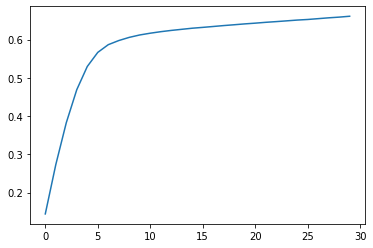

11 [1.    1.    0.999 1.   ] [0.03597293 0.04463234 0.03731573 0.0472117 ]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0569, training r2: 0.156
epoch: 2 / 30, training rmse: 0.9727, training r2: 0.2851
epoch: 3 / 30, training rmse: 0.8974, training r2: 0.3915
epoch: 4 / 30, training rmse: 0.8336, training r2: 0.475
epoch: 5 / 30, training rmse: 0.7862, training r2: 0.533
epoch: 6 / 30, training rmse: 0.7576, training r2: 0.5663
epoch: 7 / 30, training rmse: 0.7412, training r2: 0.5849
epoch: 8 / 30, training rmse: 0.7311, training r2: 0.5962
epoch: 9 / 30, training rmse: 0.7233, training r2: 0.6048
epoch: 10 / 30, training rmse: 0.7175, training r2: 0.611
epoch: 11 / 30, training rmse: 0.7129, training r2: 0.616
epoch: 12 / 30, training rmse: 0.709, training r2: 0.6202
epoch: 13 / 30, training rmse: 0.7059, training r2: 0.6235
epoch: 14 / 30, training rmse: 0.703, training r2: 0.6266
epoch: 15 / 30, training rmse: 0.6998, training r2: 0.63
epoch: 16 / 30, training rmse: 0.6974, training r2: 0.6325
epoch: 17 / 30, training rmse: 0.6956, training r2: 0.6344
epoch: 18 / 30,

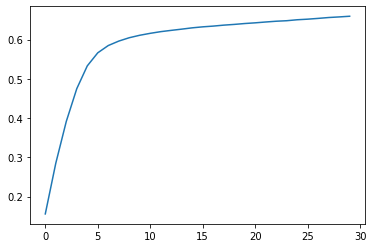

12 [1.    1.    0.992 0.998] [0.03699943 0.04418901 0.03395656 0.04871403]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0508, training r2: 0.1508
epoch: 2 / 30, training rmse: 0.9654, training r2: 0.2833
epoch: 3 / 30, training rmse: 0.8894, training r2: 0.3917
epoch: 4 / 30, training rmse: 0.8242, training r2: 0.4776
epoch: 5 / 30, training rmse: 0.7759, training r2: 0.537
epoch: 6 / 30, training rmse: 0.7464, training r2: 0.5715
epoch: 7 / 30, training rmse: 0.7298, training r2: 0.5904
epoch: 8 / 30, training rmse: 0.7197, training r2: 0.6016
epoch: 9 / 30, training rmse: 0.7121, training r2: 0.6101
epoch: 10 / 30, training rmse: 0.7063, training r2: 0.6163
epoch: 11 / 30, training rmse: 0.7016, training r2: 0.6215
epoch: 12 / 30, training rmse: 0.6983, training r2: 0.625
epoch: 13 / 30, training rmse: 0.6948, training r2: 0.6287
epoch: 14 / 30, training rmse: 0.6922, training r2: 0.6316
epoch: 15 / 30, training rmse: 0.6894, training r2: 0.6344
epoch: 16 / 30, training rmse: 0.6876, training r2: 0.6364
epoch: 17 / 30, training rmse: 0.6854, training r2: 0.6387
epoch: 1

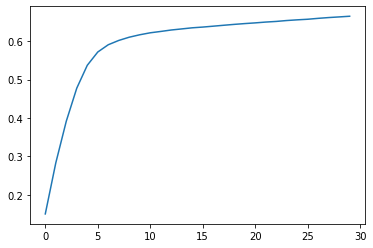

13 [1.    1.    0.992 1.   ] [0.03625105 0.04437096 0.03575091 0.0482313 ]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0652, training r2: 0.152
epoch: 2 / 30, training rmse: 0.9795, training r2: 0.283
epoch: 3 / 30, training rmse: 0.9027, training r2: 0.3911
epoch: 4 / 30, training rmse: 0.8373, training r2: 0.4761
epoch: 5 / 30, training rmse: 0.7874, training r2: 0.5367
epoch: 6 / 30, training rmse: 0.7567, training r2: 0.5721
epoch: 7 / 30, training rmse: 0.7393, training r2: 0.5916
epoch: 8 / 30, training rmse: 0.7286, training r2: 0.6033
epoch: 9 / 30, training rmse: 0.722, training r2: 0.6104
epoch: 10 / 30, training rmse: 0.7161, training r2: 0.6168
epoch: 11 / 30, training rmse: 0.7117, training r2: 0.6215
epoch: 12 / 30, training rmse: 0.7078, training r2: 0.6256
epoch: 13 / 30, training rmse: 0.7049, training r2: 0.6287
epoch: 14 / 30, training rmse: 0.7023, training r2: 0.6315
epoch: 15 / 30, training rmse: 0.6999, training r2: 0.6339
epoch: 16 / 30, training rmse: 0.6978, training r2: 0.6361
epoch: 17 / 30, training rmse: 0.6954, training r2: 0.6386
epoch: 18

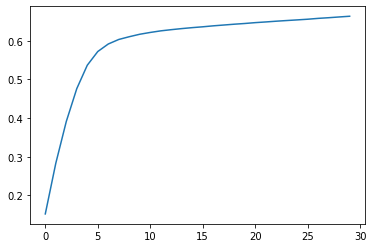

14 [1. 1. 1. 1.] [0.03698481 0.04393609 0.03701235 0.04708445]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0621, training r2: 0.1524
epoch: 2 / 30, training rmse: 0.9776, training r2: 0.2819
epoch: 3 / 30, training rmse: 0.8994, training r2: 0.3921
epoch: 4 / 30, training rmse: 0.8316, training r2: 0.4803
epoch: 5 / 30, training rmse: 0.7803, training r2: 0.5426
epoch: 6 / 30, training rmse: 0.7484, training r2: 0.5791
epoch: 7 / 30, training rmse: 0.731, training r2: 0.5984
epoch: 8 / 30, training rmse: 0.7224, training r2: 0.6079
epoch: 9 / 30, training rmse: 0.7167, training r2: 0.6141
epoch: 10 / 30, training rmse: 0.7122, training r2: 0.6188
epoch: 11 / 30, training rmse: 0.7087, training r2: 0.6226
epoch: 12 / 30, training rmse: 0.706, training r2: 0.6254
epoch: 13 / 30, training rmse: 0.7034, training r2: 0.6282
epoch: 14 / 30, training rmse: 0.7009, training r2: 0.6308
epoch: 15 / 30, training rmse: 0.6989, training r2: 0.633
epoch: 16 / 30, training rmse: 0.6969, training r2: 0.6351
epoch: 17 / 30, training rmse: 0.695, training r2: 0.6371
epoch: 18 

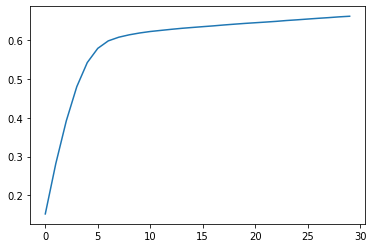

15 [1.    1.    0.991 0.998] [0.03723652 0.04367918 0.03732181 0.04780718]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.062, training r2: 0.1593
epoch: 2 / 30, training rmse: 0.9778, training r2: 0.2872
epoch: 3 / 30, training rmse: 0.902, training r2: 0.3935
epoch: 4 / 30, training rmse: 0.836, training r2: 0.479
epoch: 5 / 30, training rmse: 0.7854, training r2: 0.5401
epoch: 6 / 30, training rmse: 0.7528, training r2: 0.5775
epoch: 7 / 30, training rmse: 0.7348, training r2: 0.5975
epoch: 8 / 30, training rmse: 0.7241, training r2: 0.6091
epoch: 9 / 30, training rmse: 0.7174, training r2: 0.6164
epoch: 10 / 30, training rmse: 0.7117, training r2: 0.6224
epoch: 11 / 30, training rmse: 0.7074, training r2: 0.6269
epoch: 12 / 30, training rmse: 0.704, training r2: 0.6305
epoch: 13 / 30, training rmse: 0.7015, training r2: 0.6332
epoch: 14 / 30, training rmse: 0.6988, training r2: 0.636
epoch: 15 / 30, training rmse: 0.6963, training r2: 0.6386
epoch: 16 / 30, training rmse: 0.6937, training r2: 0.6413
epoch: 17 / 30, training rmse: 0.6919, training r2: 0.6431
epoch: 18 / 

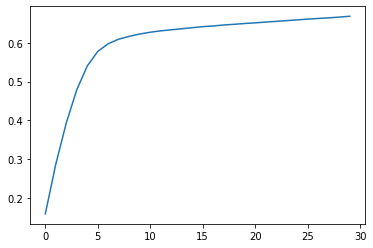

16 [1.    1.    0.997 0.998] [0.03661729 0.0441509  0.03317477 0.04916949]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0658, training r2: 0.1451
epoch: 2 / 30, training rmse: 0.9821, training r2: 0.2741
epoch: 3 / 30, training rmse: 0.9048, training r2: 0.3839
epoch: 4 / 30, training rmse: 0.837, training r2: 0.4727
epoch: 5 / 30, training rmse: 0.786, training r2: 0.535
epoch: 6 / 30, training rmse: 0.755, training r2: 0.571
epoch: 7 / 30, training rmse: 0.7372, training r2: 0.591
epoch: 8 / 30, training rmse: 0.7274, training r2: 0.6017
epoch: 9 / 30, training rmse: 0.7209, training r2: 0.6089
epoch: 10 / 30, training rmse: 0.7158, training r2: 0.6143
epoch: 11 / 30, training rmse: 0.7121, training r2: 0.6183
epoch: 12 / 30, training rmse: 0.7084, training r2: 0.6223
epoch: 13 / 30, training rmse: 0.7062, training r2: 0.6247
epoch: 14 / 30, training rmse: 0.7033, training r2: 0.6277
epoch: 15 / 30, training rmse: 0.7013, training r2: 0.6298
epoch: 16 / 30, training rmse: 0.6991, training r2: 0.6322
epoch: 17 / 30, training rmse: 0.697, training r2: 0.6344
epoch: 18 / 3

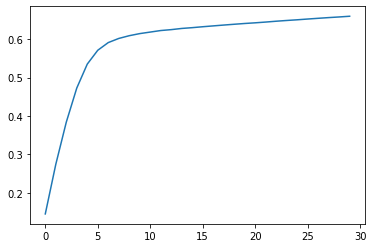

17 [1.    1.    0.999 1.   ] [0.03717331 0.0440618  0.03433411 0.0485232 ]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0527, training r2: 0.1463
epoch: 2 / 30, training rmse: 0.9715, training r2: 0.2729
epoch: 3 / 30, training rmse: 0.8972, training r2: 0.3799
epoch: 4 / 30, training rmse: 0.834, training r2: 0.4642
epoch: 5 / 30, training rmse: 0.7859, training r2: 0.5242
epoch: 6 / 30, training rmse: 0.7555, training r2: 0.5603
epoch: 7 / 30, training rmse: 0.7377, training r2: 0.5808
epoch: 8 / 30, training rmse: 0.727, training r2: 0.5929
epoch: 9 / 30, training rmse: 0.7195, training r2: 0.6013
epoch: 10 / 30, training rmse: 0.7138, training r2: 0.6076
epoch: 11 / 30, training rmse: 0.7093, training r2: 0.6124
epoch: 12 / 30, training rmse: 0.7057, training r2: 0.6164
epoch: 13 / 30, training rmse: 0.702, training r2: 0.6204
epoch: 14 / 30, training rmse: 0.6997, training r2: 0.6229
epoch: 15 / 30, training rmse: 0.6968, training r2: 0.626
epoch: 16 / 30, training rmse: 0.6948, training r2: 0.6281
epoch: 17 / 30, training rmse: 0.6927, training r2: 0.6303
epoch: 18 

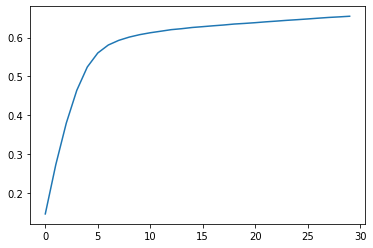

18 [1.    0.996 0.987 0.991] [0.03711997 0.04371798 0.03519789 0.04882337]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0553, training r2: 0.1572
epoch: 2 / 30, training rmse: 0.9726, training r2: 0.2842
epoch: 3 / 30, training rmse: 0.8987, training r2: 0.3888
epoch: 4 / 30, training rmse: 0.8358, training r2: 0.4714
epoch: 5 / 30, training rmse: 0.7893, training r2: 0.5285
epoch: 6 / 30, training rmse: 0.7587, training r2: 0.5644
epoch: 7 / 30, training rmse: 0.7419, training r2: 0.5835
epoch: 8 / 30, training rmse: 0.7316, training r2: 0.595
epoch: 9 / 30, training rmse: 0.7242, training r2: 0.6031
epoch: 10 / 30, training rmse: 0.7187, training r2: 0.6092
epoch: 11 / 30, training rmse: 0.7141, training r2: 0.6141
epoch: 12 / 30, training rmse: 0.7105, training r2: 0.618
epoch: 13 / 30, training rmse: 0.7074, training r2: 0.6214
epoch: 14 / 30, training rmse: 0.705, training r2: 0.6239
epoch: 15 / 30, training rmse: 0.7023, training r2: 0.6268
epoch: 16 / 30, training rmse: 0.7001, training r2: 0.6291
epoch: 17 / 30, training rmse: 0.698, training r2: 0.6313
epoch: 18 

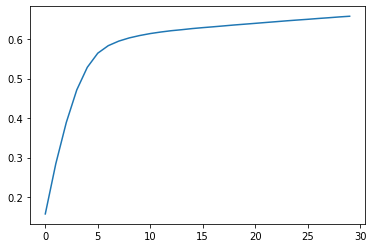

19 [1.    1.    0.997 0.999] [0.03755321 0.04440293 0.03962207 0.04763429]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0635, training r2: 0.1455
epoch: 2 / 30, training rmse: 0.9805, training r2: 0.2736
epoch: 3 / 30, training rmse: 0.9035, training r2: 0.3832
epoch: 4 / 30, training rmse: 0.8373, training r2: 0.4703
epoch: 5 / 30, training rmse: 0.7859, training r2: 0.5334
epoch: 6 / 30, training rmse: 0.7533, training r2: 0.5712
epoch: 7 / 30, training rmse: 0.7352, training r2: 0.5916
epoch: 8 / 30, training rmse: 0.7251, training r2: 0.6027
epoch: 9 / 30, training rmse: 0.7185, training r2: 0.6099
epoch: 10 / 30, training rmse: 0.7144, training r2: 0.6144
epoch: 11 / 30, training rmse: 0.7102, training r2: 0.6189
epoch: 12 / 30, training rmse: 0.7067, training r2: 0.6226
epoch: 13 / 30, training rmse: 0.7044, training r2: 0.6251
epoch: 14 / 30, training rmse: 0.7014, training r2: 0.6283
epoch: 15 / 30, training rmse: 0.6996, training r2: 0.6302
epoch: 16 / 30, training rmse: 0.6971, training r2: 0.6329
epoch: 17 / 30, training rmse: 0.695, training r2: 0.6351
epoch: 

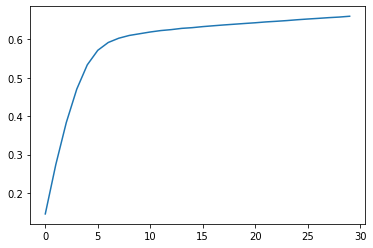

20 [1.    0.998 1.    0.999] [0.03721555 0.04374567 0.03709277 0.04869646]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0575, training r2: 0.1527
epoch: 2 / 30, training rmse: 0.9726, training r2: 0.2834
epoch: 3 / 30, training rmse: 0.8946, training r2: 0.3937
epoch: 4 / 30, training rmse: 0.8273, training r2: 0.4815
epoch: 5 / 30, training rmse: 0.7777, training r2: 0.5418
epoch: 6 / 30, training rmse: 0.747, training r2: 0.5772
epoch: 7 / 30, training rmse: 0.7301, training r2: 0.5962
epoch: 8 / 30, training rmse: 0.7207, training r2: 0.6065
epoch: 9 / 30, training rmse: 0.7143, training r2: 0.6135
epoch: 10 / 30, training rmse: 0.7098, training r2: 0.6183
epoch: 11 / 30, training rmse: 0.7058, training r2: 0.6226
epoch: 12 / 30, training rmse: 0.7029, training r2: 0.6257
epoch: 13 / 30, training rmse: 0.7001, training r2: 0.6287
epoch: 14 / 30, training rmse: 0.6975, training r2: 0.6314
epoch: 15 / 30, training rmse: 0.6952, training r2: 0.6338
epoch: 16 / 30, training rmse: 0.6933, training r2: 0.6359
epoch: 17 / 30, training rmse: 0.6909, training r2: 0.6383
epoch: 

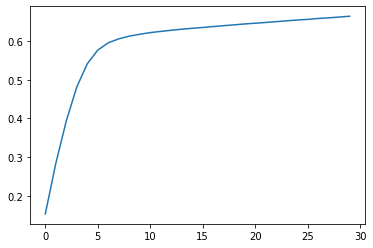

21 [1.    1.    0.996 0.998] [0.03652854 0.04527067 0.0369817  0.04859793]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw
Error in fast_horseshoe_lm(train_outcomes[i, ], Psi_o) : 
  chol(): decomposition failed
Execution halted


epoch: 1 / 30, training rmse: 1.0661, training r2: 0.139
epoch: 2 / 30, training rmse: 0.9819, training r2: 0.2696
epoch: 3 / 30, training rmse: 0.9051, training r2: 0.3794
epoch: 4 / 30, training rmse: 0.8374, training r2: 0.4688
epoch: 5 / 30, training rmse: 0.7857, training r2: 0.5323
epoch: 6 / 30, training rmse: 0.7524, training r2: 0.5711
epoch: 7 / 30, training rmse: 0.7341, training r2: 0.5917
epoch: 8 / 30, training rmse: 0.7239, training r2: 0.603
epoch: 9 / 30, training rmse: 0.7171, training r2: 0.6104
epoch: 10 / 30, training rmse: 0.7123, training r2: 0.6156
epoch: 11 / 30, training rmse: 0.7086, training r2: 0.6196
epoch: 12 / 30, training rmse: 0.7054, training r2: 0.623
epoch: 13 / 30, training rmse: 0.7027, training r2: 0.6259
epoch: 14 / 30, training rmse: 0.7002, training r2: 0.6286
epoch: 15 / 30, training rmse: 0.6981, training r2: 0.6308
epoch: 16 / 30, training rmse: 0.6958, training r2: 0.6333
epoch: 17 / 30, training rmse: 0.6938, training r2: 0.6354
epoch: 18

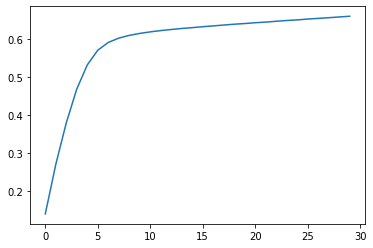

22 [0.496 0.518 0.997 0.997] [0.06159083 0.06072073 0.03624448 0.04936091]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0589, training r2: 0.1429
epoch: 2 / 30, training rmse: 0.9753, training r2: 0.2729
epoch: 3 / 30, training rmse: 0.8995, training r2: 0.3816
epoch: 4 / 30, training rmse: 0.8335, training r2: 0.469
epoch: 5 / 30, training rmse: 0.7842, training r2: 0.53
epoch: 6 / 30, training rmse: 0.7531, training r2: 0.5666
epoch: 7 / 30, training rmse: 0.736, training r2: 0.586
epoch: 8 / 30, training rmse: 0.7264, training r2: 0.5967
epoch: 9 / 30, training rmse: 0.72, training r2: 0.6037
epoch: 10 / 30, training rmse: 0.7154, training r2: 0.6088
epoch: 11 / 30, training rmse: 0.7119, training r2: 0.6127
epoch: 12 / 30, training rmse: 0.7087, training r2: 0.6161
epoch: 13 / 30, training rmse: 0.7057, training r2: 0.6194
epoch: 14 / 30, training rmse: 0.7035, training r2: 0.6217
epoch: 15 / 30, training rmse: 0.7014, training r2: 0.624
epoch: 16 / 30, training rmse: 0.6992, training r2: 0.6263
epoch: 17 / 30, training rmse: 0.6975, training r2: 0.6282
epoch: 18 / 30

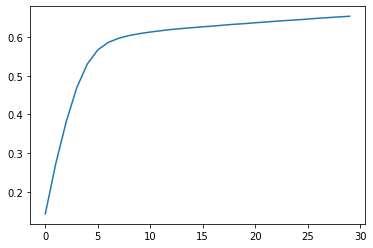

23 [1.    1.    0.994 0.999] [0.03763806 0.04411542 0.03858607 0.04700294]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0445, training r2: 0.1433
epoch: 2 / 30, training rmse: 0.9612, training r2: 0.2745
epoch: 3 / 30, training rmse: 0.8861, training r2: 0.3834
epoch: 4 / 30, training rmse: 0.8226, training r2: 0.4686
epoch: 5 / 30, training rmse: 0.7749, training r2: 0.5284
epoch: 6 / 30, training rmse: 0.7453, training r2: 0.5637
epoch: 7 / 30, training rmse: 0.7288, training r2: 0.5829
epoch: 8 / 30, training rmse: 0.7185, training r2: 0.5946
epoch: 9 / 30, training rmse: 0.7108, training r2: 0.6032
epoch: 10 / 30, training rmse: 0.7048, training r2: 0.6099
epoch: 11 / 30, training rmse: 0.7002, training r2: 0.615
epoch: 12 / 30, training rmse: 0.6969, training r2: 0.6186
epoch: 13 / 30, training rmse: 0.6934, training r2: 0.6224
epoch: 14 / 30, training rmse: 0.691, training r2: 0.6251
epoch: 15 / 30, training rmse: 0.6885, training r2: 0.6277
epoch: 16 / 30, training rmse: 0.6861, training r2: 0.6303
epoch: 17 / 30, training rmse: 0.6838, training r2: 0.6328
epoch: 1

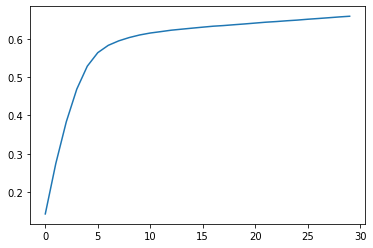

24 [1. 1. 1. 1.] [0.0359515  0.04512037 0.03944612 0.04639009]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0598, training r2: 0.1475
epoch: 2 / 30, training rmse: 0.9743, training r2: 0.2795
epoch: 3 / 30, training rmse: 0.8967, training r2: 0.3897
epoch: 4 / 30, training rmse: 0.8301, training r2: 0.477
epoch: 5 / 30, training rmse: 0.779, training r2: 0.5394
epoch: 6 / 30, training rmse: 0.7468, training r2: 0.5767
epoch: 7 / 30, training rmse: 0.7292, training r2: 0.5965
epoch: 8 / 30, training rmse: 0.7195, training r2: 0.6071
epoch: 9 / 30, training rmse: 0.7129, training r2: 0.6143
epoch: 10 / 30, training rmse: 0.7078, training r2: 0.6198
epoch: 11 / 30, training rmse: 0.7039, training r2: 0.6239
epoch: 12 / 30, training rmse: 0.7006, training r2: 0.6275
epoch: 13 / 30, training rmse: 0.6981, training r2: 0.6301
epoch: 14 / 30, training rmse: 0.6952, training r2: 0.6331
epoch: 15 / 30, training rmse: 0.6933, training r2: 0.6352
epoch: 16 / 30, training rmse: 0.691, training r2: 0.6376
epoch: 17 / 30, training rmse: 0.689, training r2: 0.6397
epoch: 18 

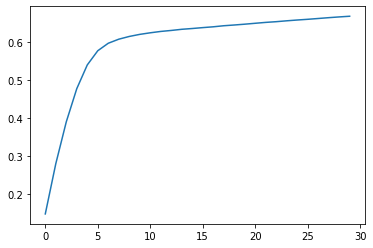

25 [1.    1.    0.975 0.986] [0.03654751 0.04486995 0.03699445 0.04826028]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0418, training r2: 0.1422
epoch: 2 / 30, training rmse: 0.958, training r2: 0.2747
epoch: 3 / 30, training rmse: 0.8823, training r2: 0.3848
epoch: 4 / 30, training rmse: 0.8173, training r2: 0.4721
epoch: 5 / 30, training rmse: 0.7693, training r2: 0.5323
epoch: 6 / 30, training rmse: 0.7397, training r2: 0.5676
epoch: 7 / 30, training rmse: 0.7236, training r2: 0.5862
epoch: 8 / 30, training rmse: 0.7148, training r2: 0.5962
epoch: 9 / 30, training rmse: 0.7082, training r2: 0.6036
epoch: 10 / 30, training rmse: 0.7032, training r2: 0.6092
epoch: 11 / 30, training rmse: 0.6996, training r2: 0.6131
epoch: 12 / 30, training rmse: 0.6964, training r2: 0.6167
epoch: 13 / 30, training rmse: 0.6932, training r2: 0.6202
epoch: 14 / 30, training rmse: 0.6907, training r2: 0.6229
epoch: 15 / 30, training rmse: 0.6885, training r2: 0.6253
epoch: 16 / 30, training rmse: 0.6864, training r2: 0.6276
epoch: 17 / 30, training rmse: 0.6842, training r2: 0.63
epoch: 18

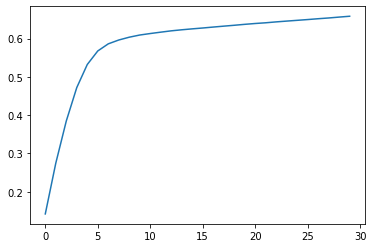

26 [1.    1.    1.    0.999] [0.03585132 0.04338477 0.03824339 0.04547033]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0506, training r2: 0.142
epoch: 2 / 30, training rmse: 0.9683, training r2: 0.2712
epoch: 3 / 30, training rmse: 0.8919, training r2: 0.3816
epoch: 4 / 30, training rmse: 0.8267, training r2: 0.4688
epoch: 5 / 30, training rmse: 0.7778, training r2: 0.5298
epoch: 6 / 30, training rmse: 0.7462, training r2: 0.5672
epoch: 7 / 30, training rmse: 0.7282, training r2: 0.5878
epoch: 8 / 30, training rmse: 0.7178, training r2: 0.5995
epoch: 9 / 30, training rmse: 0.7101, training r2: 0.6081
epoch: 10 / 30, training rmse: 0.7045, training r2: 0.6143
epoch: 11 / 30, training rmse: 0.7002, training r2: 0.619
epoch: 12 / 30, training rmse: 0.6966, training r2: 0.6228
epoch: 13 / 30, training rmse: 0.694, training r2: 0.6256
epoch: 14 / 30, training rmse: 0.6915, training r2: 0.6283
epoch: 15 / 30, training rmse: 0.6893, training r2: 0.6307
epoch: 16 / 30, training rmse: 0.6871, training r2: 0.633
epoch: 17 / 30, training rmse: 0.6851, training r2: 0.6351
epoch: 18 

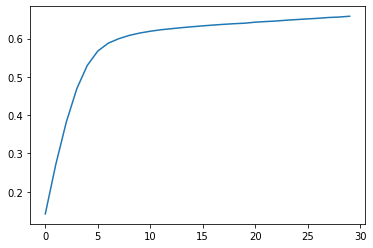

27 [1.    1.    0.973 0.983] [0.0369027  0.04453629 0.0388483  0.04698695]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0622, training r2: 0.1525
epoch: 2 / 30, training rmse: 0.9773, training r2: 0.2826
epoch: 3 / 30, training rmse: 0.9018, training r2: 0.3892
epoch: 4 / 30, training rmse: 0.8371, training r2: 0.4737
epoch: 5 / 30, training rmse: 0.7879, training r2: 0.5337
epoch: 6 / 30, training rmse: 0.7572, training r2: 0.5694
epoch: 7 / 30, training rmse: 0.7396, training r2: 0.5891
epoch: 8 / 30, training rmse: 0.7292, training r2: 0.6006
epoch: 9 / 30, training rmse: 0.7215, training r2: 0.609
epoch: 10 / 30, training rmse: 0.7159, training r2: 0.615
epoch: 11 / 30, training rmse: 0.7111, training r2: 0.6201
epoch: 12 / 30, training rmse: 0.7081, training r2: 0.6234
epoch: 13 / 30, training rmse: 0.705, training r2: 0.6266
epoch: 14 / 30, training rmse: 0.7023, training r2: 0.6295
epoch: 15 / 30, training rmse: 0.6996, training r2: 0.6323
epoch: 16 / 30, training rmse: 0.6977, training r2: 0.6344
epoch: 17 / 30, training rmse: 0.6952, training r2: 0.637
epoch: 18 

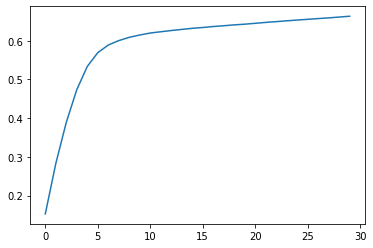

28 [1.    1.    0.998 0.999] [0.03693085 0.04323742 0.04006697 0.04406707]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.05, training r2: 0.1562
epoch: 2 / 30, training rmse: 0.969, training r2: 0.2813
epoch: 3 / 30, training rmse: 0.8964, training r2: 0.385
epoch: 4 / 30, training rmse: 0.8349, training r2: 0.4665
epoch: 5 / 30, training rmse: 0.7887, training r2: 0.5239
epoch: 6 / 30, training rmse: 0.7587, training r2: 0.5594
epoch: 7 / 30, training rmse: 0.7403, training r2: 0.5805
epoch: 8 / 30, training rmse: 0.729, training r2: 0.5932
epoch: 9 / 30, training rmse: 0.7206, training r2: 0.6026
epoch: 10 / 30, training rmse: 0.7139, training r2: 0.6099
epoch: 11 / 30, training rmse: 0.7087, training r2: 0.6156
epoch: 12 / 30, training rmse: 0.7047, training r2: 0.6199
epoch: 13 / 30, training rmse: 0.7011, training r2: 0.6238
epoch: 14 / 30, training rmse: 0.6983, training r2: 0.6268
epoch: 15 / 30, training rmse: 0.6953, training r2: 0.6299
epoch: 16 / 30, training rmse: 0.693, training r2: 0.6324
epoch: 17 / 30, training rmse: 0.6908, training r2: 0.6348
epoch: 18 / 

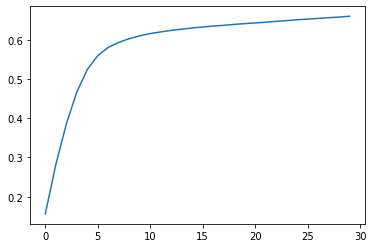

29 [1.    1.    0.999 1.   ] [0.03665043 0.04370154 0.03302277 0.04977435]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0698, training r2: 0.1534
epoch: 2 / 30, training rmse: 0.9861, training r2: 0.2808
epoch: 3 / 30, training rmse: 0.91, training r2: 0.3875
epoch: 4 / 30, training rmse: 0.844, training r2: 0.4731
epoch: 5 / 30, training rmse: 0.7927, training r2: 0.5352
epoch: 6 / 30, training rmse: 0.7595, training r2: 0.5733
epoch: 7 / 30, training rmse: 0.7405, training r2: 0.5943
epoch: 8 / 30, training rmse: 0.7294, training r2: 0.6064
epoch: 9 / 30, training rmse: 0.7219, training r2: 0.6145
epoch: 10 / 30, training rmse: 0.7156, training r2: 0.6212
epoch: 11 / 30, training rmse: 0.7106, training r2: 0.6265
epoch: 12 / 30, training rmse: 0.7063, training r2: 0.631
epoch: 13 / 30, training rmse: 0.7032, training r2: 0.6342
epoch: 14 / 30, training rmse: 0.6999, training r2: 0.6376
epoch: 15 / 30, training rmse: 0.6975, training r2: 0.6402
epoch: 16 / 30, training rmse: 0.6951, training r2: 0.6426
epoch: 17 / 30, training rmse: 0.6927, training r2: 0.645
epoch: 18 /

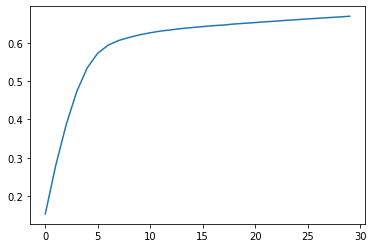

30 [1.    1.    0.999 0.999] [0.03681941 0.04398235 0.04041916 0.04608573]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0609, training r2: 0.1429
epoch: 2 / 30, training rmse: 0.9774, training r2: 0.2724
epoch: 3 / 30, training rmse: 0.9015, training r2: 0.3811
epoch: 4 / 30, training rmse: 0.8343, training r2: 0.4699
epoch: 5 / 30, training rmse: 0.7835, training r2: 0.5325
epoch: 6 / 30, training rmse: 0.7497, training r2: 0.5719
epoch: 7 / 30, training rmse: 0.7319, training r2: 0.592
epoch: 8 / 30, training rmse: 0.7217, training r2: 0.6034
epoch: 9 / 30, training rmse: 0.7149, training r2: 0.6107
epoch: 10 / 30, training rmse: 0.7093, training r2: 0.6168
epoch: 11 / 30, training rmse: 0.7043, training r2: 0.6222
epoch: 12 / 30, training rmse: 0.7008, training r2: 0.626
epoch: 13 / 30, training rmse: 0.6974, training r2: 0.6296
epoch: 14 / 30, training rmse: 0.6946, training r2: 0.6325
epoch: 15 / 30, training rmse: 0.6922, training r2: 0.6351
epoch: 16 / 30, training rmse: 0.6896, training r2: 0.6378
epoch: 17 / 30, training rmse: 0.6874, training r2: 0.6401
epoch: 1

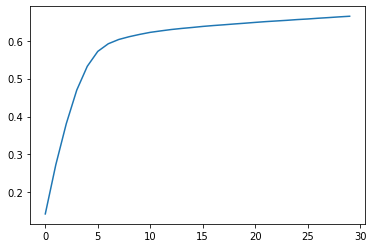

31 [1.    1.    0.997 0.997] [0.03663133 0.04479508 0.03498715 0.04935262]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0537, training r2: 0.1462
epoch: 2 / 30, training rmse: 0.9686, training r2: 0.2786
epoch: 3 / 30, training rmse: 0.8924, training r2: 0.3876
epoch: 4 / 30, training rmse: 0.8275, training r2: 0.4734
epoch: 5 / 30, training rmse: 0.7793, training r2: 0.5329
epoch: 6 / 30, training rmse: 0.7495, training r2: 0.568
epoch: 7 / 30, training rmse: 0.7331, training r2: 0.5868
epoch: 8 / 30, training rmse: 0.7229, training r2: 0.5981
epoch: 9 / 30, training rmse: 0.7158, training r2: 0.606
epoch: 10 / 30, training rmse: 0.7106, training r2: 0.6117
epoch: 11 / 30, training rmse: 0.7063, training r2: 0.6164
epoch: 12 / 30, training rmse: 0.7024, training r2: 0.6206
epoch: 13 / 30, training rmse: 0.6995, training r2: 0.6237
epoch: 14 / 30, training rmse: 0.6965, training r2: 0.6269
epoch: 15 / 30, training rmse: 0.6942, training r2: 0.6294
epoch: 16 / 30, training rmse: 0.6923, training r2: 0.6315
epoch: 17 / 30, training rmse: 0.6898, training r2: 0.6341
epoch: 1

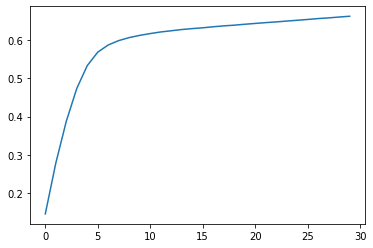

32 [1.    1.    0.994 0.999] [0.03585347 0.04372072 0.03524776 0.04774344]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw
Error in fast_horseshoe_lm(train_outcomes[i, ], Psi_o) : 
  chol(): decomposition failed
Execution halted


epoch: 1 / 30, training rmse: 1.0524, training r2: 0.1483
epoch: 2 / 30, training rmse: 0.9705, training r2: 0.2757
epoch: 3 / 30, training rmse: 0.8961, training r2: 0.3825
epoch: 4 / 30, training rmse: 0.8332, training r2: 0.4662
epoch: 5 / 30, training rmse: 0.7854, training r2: 0.5257
epoch: 6 / 30, training rmse: 0.7554, training r2: 0.5612
epoch: 7 / 30, training rmse: 0.7388, training r2: 0.5803
epoch: 8 / 30, training rmse: 0.7288, training r2: 0.5916
epoch: 9 / 30, training rmse: 0.7211, training r2: 0.6001
epoch: 10 / 30, training rmse: 0.7153, training r2: 0.6066
epoch: 11 / 30, training rmse: 0.711, training r2: 0.6112
epoch: 12 / 30, training rmse: 0.7077, training r2: 0.6149
epoch: 13 / 30, training rmse: 0.7044, training r2: 0.6185
epoch: 14 / 30, training rmse: 0.702, training r2: 0.6211
epoch: 15 / 30, training rmse: 0.6998, training r2: 0.6234
epoch: 16 / 30, training rmse: 0.6975, training r2: 0.6259
epoch: 17 / 30, training rmse: 0.6958, training r2: 0.6277
epoch: 1

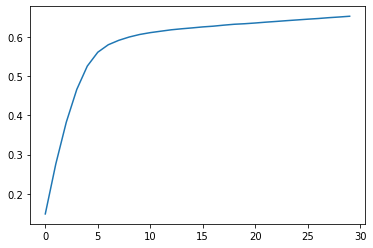

33 [0.527 0.497 0.996 0.992] [0.06053085 0.05890499 0.0357524  0.04788927]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0549, training r2: 0.1449
epoch: 2 / 30, training rmse: 0.9692, training r2: 0.2783
epoch: 3 / 30, training rmse: 0.8922, training r2: 0.3883
epoch: 4 / 30, training rmse: 0.8253, training r2: 0.4766
epoch: 5 / 30, training rmse: 0.7746, training r2: 0.539
epoch: 6 / 30, training rmse: 0.7426, training r2: 0.5763
epoch: 7 / 30, training rmse: 0.7249, training r2: 0.5963
epoch: 8 / 30, training rmse: 0.715, training r2: 0.6071
epoch: 9 / 30, training rmse: 0.7091, training r2: 0.6137
epoch: 10 / 30, training rmse: 0.7036, training r2: 0.6196
epoch: 11 / 30, training rmse: 0.6999, training r2: 0.6236
epoch: 12 / 30, training rmse: 0.697, training r2: 0.6267
epoch: 13 / 30, training rmse: 0.6943, training r2: 0.6296
epoch: 14 / 30, training rmse: 0.6916, training r2: 0.6325
epoch: 15 / 30, training rmse: 0.6894, training r2: 0.6348
epoch: 16 / 30, training rmse: 0.6873, training r2: 0.6371
epoch: 17 / 30, training rmse: 0.6855, training r2: 0.639
epoch: 18 

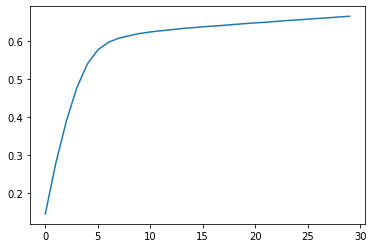

34 [1.    1.    0.999 0.999] [0.03566639 0.04584154 0.03389485 0.05022725]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.051, training r2: 0.1579
epoch: 2 / 30, training rmse: 0.9662, training r2: 0.2882
epoch: 3 / 30, training rmse: 0.8906, training r2: 0.3953
epoch: 4 / 30, training rmse: 0.8261, training r2: 0.4797
epoch: 5 / 30, training rmse: 0.777, training r2: 0.5397
epoch: 6 / 30, training rmse: 0.7471, training r2: 0.5744
epoch: 7 / 30, training rmse: 0.731, training r2: 0.5926
epoch: 8 / 30, training rmse: 0.7214, training r2: 0.6032
epoch: 9 / 30, training rmse: 0.715, training r2: 0.6102
epoch: 10 / 30, training rmse: 0.7097, training r2: 0.616
epoch: 11 / 30, training rmse: 0.7055, training r2: 0.6205
epoch: 12 / 30, training rmse: 0.7021, training r2: 0.6242
epoch: 13 / 30, training rmse: 0.699, training r2: 0.6275
epoch: 14 / 30, training rmse: 0.6963, training r2: 0.6303
epoch: 15 / 30, training rmse: 0.6937, training r2: 0.6331
epoch: 16 / 30, training rmse: 0.6916, training r2: 0.6354
epoch: 17 / 30, training rmse: 0.6889, training r2: 0.6382
epoch: 18 / 

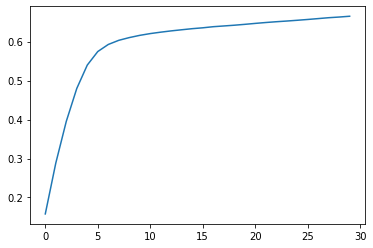

35 [1.    1.    0.998 0.998] [0.03614283 0.04451361 0.03509947 0.04784324]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0627, training r2: 0.1429
epoch: 2 / 30, training rmse: 0.9803, training r2: 0.2706
epoch: 3 / 30, training rmse: 0.9066, training r2: 0.3762
epoch: 4 / 30, training rmse: 0.8434, training r2: 0.4601
epoch: 5 / 30, training rmse: 0.7952, training r2: 0.5201
epoch: 6 / 30, training rmse: 0.7645, training r2: 0.5565
epoch: 7 / 30, training rmse: 0.7469, training r2: 0.5766
epoch: 8 / 30, training rmse: 0.7362, training r2: 0.5887
epoch: 9 / 30, training rmse: 0.7281, training r2: 0.5977
epoch: 10 / 30, training rmse: 0.7221, training r2: 0.6043
epoch: 11 / 30, training rmse: 0.7169, training r2: 0.6099
epoch: 12 / 30, training rmse: 0.7129, training r2: 0.6143
epoch: 13 / 30, training rmse: 0.7096, training r2: 0.6179
epoch: 14 / 30, training rmse: 0.7067, training r2: 0.621
epoch: 15 / 30, training rmse: 0.7039, training r2: 0.624
epoch: 16 / 30, training rmse: 0.7013, training r2: 0.6267
epoch: 17 / 30, training rmse: 0.6994, training r2: 0.6288
epoch: 1

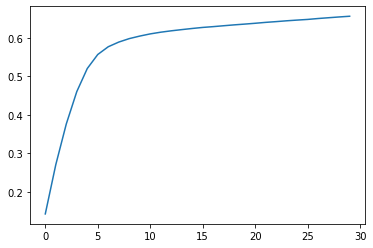

36 [1.   1.   0.99 0.99] [0.03742779 0.04553107 0.03798674 0.04889296]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0513, training r2: 0.156
epoch: 2 / 30, training rmse: 0.9678, training r2: 0.2847
epoch: 3 / 30, training rmse: 0.8924, training r2: 0.3919
epoch: 4 / 30, training rmse: 0.8293, training r2: 0.4748
epoch: 5 / 30, training rmse: 0.7824, training r2: 0.5325
epoch: 6 / 30, training rmse: 0.7543, training r2: 0.5655
epoch: 7 / 30, training rmse: 0.7382, training r2: 0.5839
epoch: 8 / 30, training rmse: 0.7286, training r2: 0.5946
epoch: 9 / 30, training rmse: 0.7213, training r2: 0.6027
epoch: 10 / 30, training rmse: 0.715, training r2: 0.6095
epoch: 11 / 30, training rmse: 0.7098, training r2: 0.6152
epoch: 12 / 30, training rmse: 0.7058, training r2: 0.6195
epoch: 13 / 30, training rmse: 0.7027, training r2: 0.6229
epoch: 14 / 30, training rmse: 0.6997, training r2: 0.6261
epoch: 15 / 30, training rmse: 0.6969, training r2: 0.6291
epoch: 16 / 30, training rmse: 0.6946, training r2: 0.6315
epoch: 17 / 30, training rmse: 0.6923, training r2: 0.634
epoch: 18

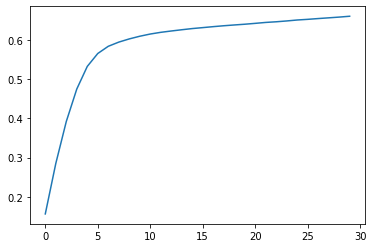

37 [1.    1.    0.992 0.999] [0.03659562 0.04503658 0.03670695 0.04781012]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0591, training r2: 0.1474
epoch: 2 / 30, training rmse: 0.9747, training r2: 0.2779
epoch: 3 / 30, training rmse: 0.9017, training r2: 0.3821
epoch: 4 / 30, training rmse: 0.8394, training r2: 0.4645
epoch: 5 / 30, training rmse: 0.792, training r2: 0.5232
epoch: 6 / 30, training rmse: 0.7607, training r2: 0.5602
epoch: 7 / 30, training rmse: 0.7427, training r2: 0.5808
epoch: 8 / 30, training rmse: 0.7311, training r2: 0.5938
epoch: 9 / 30, training rmse: 0.7224, training r2: 0.6033
epoch: 10 / 30, training rmse: 0.7159, training r2: 0.6105
epoch: 11 / 30, training rmse: 0.7101, training r2: 0.6167
epoch: 12 / 30, training rmse: 0.705, training r2: 0.6222
epoch: 13 / 30, training rmse: 0.7008, training r2: 0.6267
epoch: 14 / 30, training rmse: 0.6976, training r2: 0.6301
epoch: 15 / 30, training rmse: 0.6945, training r2: 0.6334
epoch: 16 / 30, training rmse: 0.6924, training r2: 0.6356
epoch: 17 / 30, training rmse: 0.6895, training r2: 0.6386
epoch: 1

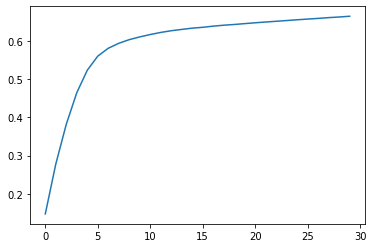

38 [1.    1.    0.998 0.999] [0.03618916 0.04395414 0.03859448 0.04553241]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0583, training r2: 0.156
epoch: 2 / 30, training rmse: 0.9755, training r2: 0.2829
epoch: 3 / 30, training rmse: 0.902, training r2: 0.3869
epoch: 4 / 30, training rmse: 0.8391, training r2: 0.4694
epoch: 5 / 30, training rmse: 0.7926, training r2: 0.5266
epoch: 6 / 30, training rmse: 0.763, training r2: 0.5613
epoch: 7 / 30, training rmse: 0.7461, training r2: 0.5805
epoch: 8 / 30, training rmse: 0.7358, training r2: 0.592
epoch: 9 / 30, training rmse: 0.7288, training r2: 0.5997
epoch: 10 / 30, training rmse: 0.7225, training r2: 0.6066
epoch: 11 / 30, training rmse: 0.7178, training r2: 0.6117
epoch: 12 / 30, training rmse: 0.7141, training r2: 0.6157
epoch: 13 / 30, training rmse: 0.7109, training r2: 0.6192
epoch: 14 / 30, training rmse: 0.7079, training r2: 0.6223
epoch: 15 / 30, training rmse: 0.7058, training r2: 0.6246
epoch: 16 / 30, training rmse: 0.7033, training r2: 0.6272
epoch: 17 / 30, training rmse: 0.7011, training r2: 0.6296
epoch: 18 

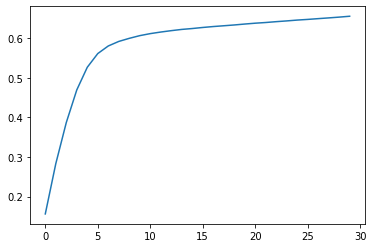

39 [1.    1.    0.98  0.988] [0.03776853 0.04454987 0.03517609 0.04949513]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0569, training r2: 0.1572
epoch: 2 / 30, training rmse: 0.9747, training r2: 0.2832
epoch: 3 / 30, training rmse: 0.9024, training r2: 0.3856
epoch: 4 / 30, training rmse: 0.8407, training r2: 0.4668
epoch: 5 / 30, training rmse: 0.7942, training r2: 0.5242
epoch: 6 / 30, training rmse: 0.7654, training r2: 0.558
epoch: 7 / 30, training rmse: 0.748, training r2: 0.5778
epoch: 8 / 30, training rmse: 0.7367, training r2: 0.5906
epoch: 9 / 30, training rmse: 0.7284, training r2: 0.5997
epoch: 10 / 30, training rmse: 0.7213, training r2: 0.6075
epoch: 11 / 30, training rmse: 0.7154, training r2: 0.6138
epoch: 12 / 30, training rmse: 0.7111, training r2: 0.6185
epoch: 13 / 30, training rmse: 0.7072, training r2: 0.6227
epoch: 14 / 30, training rmse: 0.7041, training r2: 0.626
epoch: 15 / 30, training rmse: 0.7013, training r2: 0.6289
epoch: 16 / 30, training rmse: 0.6989, training r2: 0.6315
epoch: 17 / 30, training rmse: 0.6964, training r2: 0.6341
epoch: 18

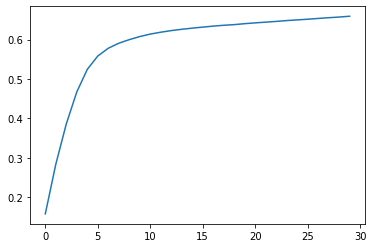

40 [1.    1.    0.994 0.997] [0.03716635 0.04386818 0.03728396 0.04732075]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0583, training r2: 0.1484
epoch: 2 / 30, training rmse: 0.9753, training r2: 0.2767
epoch: 3 / 30, training rmse: 0.9016, training r2: 0.3819
epoch: 4 / 30, training rmse: 0.8389, training r2: 0.4649
epoch: 5 / 30, training rmse: 0.7918, training r2: 0.5232
epoch: 6 / 30, training rmse: 0.7614, training r2: 0.5591
epoch: 7 / 30, training rmse: 0.7431, training r2: 0.58
epoch: 8 / 30, training rmse: 0.7323, training r2: 0.5922
epoch: 9 / 30, training rmse: 0.7247, training r2: 0.6006
epoch: 10 / 30, training rmse: 0.7186, training r2: 0.6073
epoch: 11 / 30, training rmse: 0.7142, training r2: 0.6121
epoch: 12 / 30, training rmse: 0.7103, training r2: 0.6163
epoch: 13 / 30, training rmse: 0.7077, training r2: 0.6192
epoch: 14 / 30, training rmse: 0.7046, training r2: 0.6225
epoch: 15 / 30, training rmse: 0.7024, training r2: 0.6249
epoch: 16 / 30, training rmse: 0.7001, training r2: 0.6273
epoch: 17 / 30, training rmse: 0.6981, training r2: 0.6294
epoch: 1

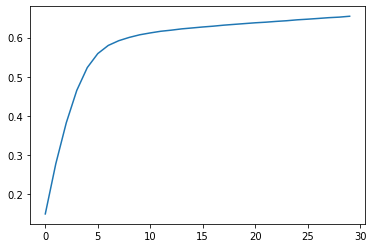

41 [1.    1.    0.993 0.994] [0.03758707 0.04469123 0.03764527 0.04895378]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0631, training r2: 0.1453
epoch: 2 / 30, training rmse: 0.9793, training r2: 0.2747
epoch: 3 / 30, training rmse: 0.9024, training r2: 0.3842
epoch: 4 / 30, training rmse: 0.8349, training r2: 0.4729
epoch: 5 / 30, training rmse: 0.7824, training r2: 0.537
epoch: 6 / 30, training rmse: 0.7495, training r2: 0.5752
epoch: 7 / 30, training rmse: 0.7314, training r2: 0.5955
epoch: 8 / 30, training rmse: 0.7227, training r2: 0.6051
epoch: 9 / 30, training rmse: 0.7162, training r2: 0.6121
epoch: 10 / 30, training rmse: 0.7112, training r2: 0.6175
epoch: 11 / 30, training rmse: 0.7071, training r2: 0.6219
epoch: 12 / 30, training rmse: 0.7039, training r2: 0.6253
epoch: 13 / 30, training rmse: 0.7013, training r2: 0.6281
epoch: 14 / 30, training rmse: 0.6993, training r2: 0.6302
epoch: 15 / 30, training rmse: 0.6963, training r2: 0.6334
epoch: 16 / 30, training rmse: 0.6943, training r2: 0.6354
epoch: 17 / 30, training rmse: 0.6919, training r2: 0.638
epoch: 1

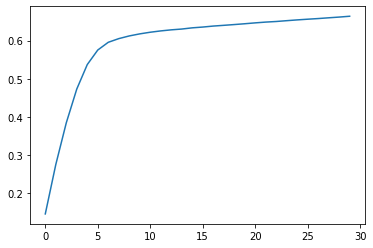

42 [1.    1.    0.999 1.   ] [0.03639101 0.04249906 0.03522467 0.04703581]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0555, training r2: 0.1514
epoch: 2 / 30, training rmse: 0.9735, training r2: 0.2782
epoch: 3 / 30, training rmse: 0.9004, training r2: 0.3824
epoch: 4 / 30, training rmse: 0.8377, training r2: 0.4655
epoch: 5 / 30, training rmse: 0.7902, training r2: 0.5244
epoch: 6 / 30, training rmse: 0.7603, training r2: 0.5597
epoch: 7 / 30, training rmse: 0.7436, training r2: 0.5789
epoch: 8 / 30, training rmse: 0.7339, training r2: 0.5897
epoch: 9 / 30, training rmse: 0.7268, training r2: 0.5977
epoch: 10 / 30, training rmse: 0.7214, training r2: 0.6036
epoch: 11 / 30, training rmse: 0.717, training r2: 0.6085
epoch: 12 / 30, training rmse: 0.7136, training r2: 0.6121
epoch: 13 / 30, training rmse: 0.7106, training r2: 0.6154
epoch: 14 / 30, training rmse: 0.7083, training r2: 0.6179
epoch: 15 / 30, training rmse: 0.7059, training r2: 0.6204
epoch: 16 / 30, training rmse: 0.7033, training r2: 0.6232
epoch: 17 / 30, training rmse: 0.7014, training r2: 0.6252
epoch: 

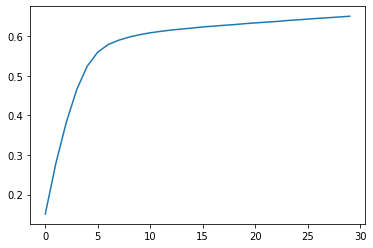

43 [1.    1.    0.987 0.995] [0.03739249 0.04476322 0.03515576 0.05039389]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw
Error in fast_horseshoe_lm(test_outcomes[i, ], Psi_o) : 
  chol(): decomposition failed
Execution halted


epoch: 1 / 30, training rmse: 1.0606, training r2: 0.1431
epoch: 2 / 30, training rmse: 0.9771, training r2: 0.2727
epoch: 3 / 30, training rmse: 0.9029, training r2: 0.3791
epoch: 4 / 30, training rmse: 0.8387, training r2: 0.4642
epoch: 5 / 30, training rmse: 0.79, training r2: 0.5246
epoch: 6 / 30, training rmse: 0.7601, training r2: 0.5599
epoch: 7 / 30, training rmse: 0.7428, training r2: 0.5797
epoch: 8 / 30, training rmse: 0.7324, training r2: 0.5914
epoch: 9 / 30, training rmse: 0.725, training r2: 0.5996
epoch: 10 / 30, training rmse: 0.7201, training r2: 0.605
epoch: 11 / 30, training rmse: 0.7155, training r2: 0.61
epoch: 12 / 30, training rmse: 0.7117, training r2: 0.6141
epoch: 13 / 30, training rmse: 0.7091, training r2: 0.617
epoch: 14 / 30, training rmse: 0.7065, training r2: 0.6198
epoch: 15 / 30, training rmse: 0.7041, training r2: 0.6224
epoch: 16 / 30, training rmse: 0.7021, training r2: 0.6245
epoch: 17 / 30, training rmse: 0.6995, training r2: 0.6273
epoch: 18 / 3

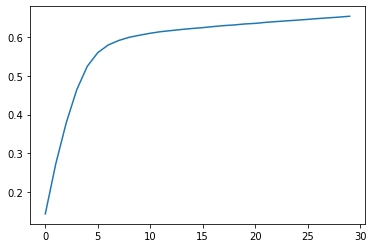

44 [0.492 0.461 0.996 1.   ] [0.06136607 0.06200699 0.03474039 0.04972734]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0659, training r2: 0.1411
epoch: 2 / 30, training rmse: 0.9813, training r2: 0.272
epoch: 3 / 30, training rmse: 0.9055, training r2: 0.3802
epoch: 4 / 30, training rmse: 0.8389, training r2: 0.468
epoch: 5 / 30, training rmse: 0.7876, training r2: 0.5311
epoch: 6 / 30, training rmse: 0.7545, training r2: 0.5697
epoch: 7 / 30, training rmse: 0.7352, training r2: 0.5913
epoch: 8 / 30, training rmse: 0.7248, training r2: 0.6029
epoch: 9 / 30, training rmse: 0.7174, training r2: 0.6109
epoch: 10 / 30, training rmse: 0.7119, training r2: 0.6169
epoch: 11 / 30, training rmse: 0.7074, training r2: 0.6217
epoch: 12 / 30, training rmse: 0.7041, training r2: 0.6252
epoch: 13 / 30, training rmse: 0.7012, training r2: 0.6282
epoch: 14 / 30, training rmse: 0.6985, training r2: 0.6311
epoch: 15 / 30, training rmse: 0.6962, training r2: 0.6335
epoch: 16 / 30, training rmse: 0.6935, training r2: 0.6364
epoch: 17 / 30, training rmse: 0.6912, training r2: 0.6388
epoch: 1

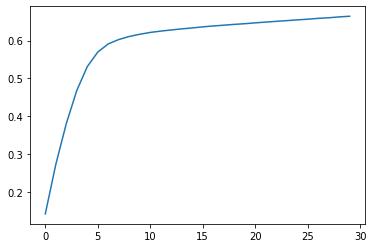

45 [1.    0.999 1.    1.   ] [0.03719739 0.04531826 0.03709381 0.04799204]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0714, training r2: 0.145
epoch: 2 / 30, training rmse: 0.9847, training r2: 0.2778
epoch: 3 / 30, training rmse: 0.9058, training r2: 0.3889
epoch: 4 / 30, training rmse: 0.8383, training r2: 0.4766
epoch: 5 / 30, training rmse: 0.7881, training r2: 0.5374
epoch: 6 / 30, training rmse: 0.7568, training r2: 0.5734
epoch: 7 / 30, training rmse: 0.7397, training r2: 0.5924
epoch: 8 / 30, training rmse: 0.7303, training r2: 0.6027
epoch: 9 / 30, training rmse: 0.7232, training r2: 0.6104
epoch: 10 / 30, training rmse: 0.7187, training r2: 0.6153
epoch: 11 / 30, training rmse: 0.7143, training r2: 0.62
epoch: 12 / 30, training rmse: 0.7108, training r2: 0.6236
epoch: 13 / 30, training rmse: 0.7077, training r2: 0.627
epoch: 14 / 30, training rmse: 0.7054, training r2: 0.6294
epoch: 15 / 30, training rmse: 0.7024, training r2: 0.6326
epoch: 16 / 30, training rmse: 0.7, training r2: 0.635
epoch: 17 / 30, training rmse: 0.6977, training r2: 0.6375
epoch: 18 / 30

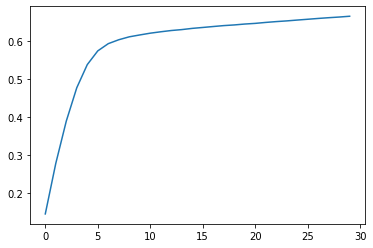

46 [1.    1.    0.997 1.   ] [0.03720966 0.04569933 0.03988066 0.04761736]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.069, training r2: 0.1514
epoch: 2 / 30, training rmse: 0.9832, training r2: 0.2822
epoch: 3 / 30, training rmse: 0.9061, training r2: 0.3904
epoch: 4 / 30, training rmse: 0.8403, training r2: 0.4757
epoch: 5 / 30, training rmse: 0.7895, training r2: 0.5371
epoch: 6 / 30, training rmse: 0.7581, training r2: 0.5733
epoch: 7 / 30, training rmse: 0.7402, training r2: 0.5932
epoch: 8 / 30, training rmse: 0.7296, training r2: 0.6047
epoch: 9 / 30, training rmse: 0.7223, training r2: 0.6126
epoch: 10 / 30, training rmse: 0.7166, training r2: 0.6187
epoch: 11 / 30, training rmse: 0.7119, training r2: 0.6237
epoch: 12 / 30, training rmse: 0.7082, training r2: 0.6276
epoch: 13 / 30, training rmse: 0.705, training r2: 0.631
epoch: 14 / 30, training rmse: 0.7023, training r2: 0.6338
epoch: 15 / 30, training rmse: 0.6994, training r2: 0.6368
epoch: 16 / 30, training rmse: 0.6973, training r2: 0.639
epoch: 17 / 30, training rmse: 0.6948, training r2: 0.6416
epoch: 18 

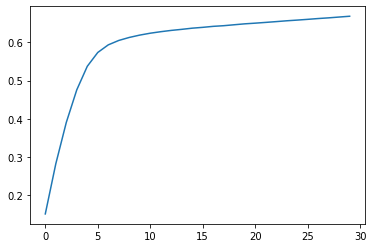

47 [1.    1.    0.998 0.998] [0.03663395 0.04394354 0.03475663 0.0495648 ]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0599, training r2: 0.1394
epoch: 2 / 30, training rmse: 0.9756, training r2: 0.2709
epoch: 3 / 30, training rmse: 0.8995, training r2: 0.3801
epoch: 4 / 30, training rmse: 0.8333, training r2: 0.4681
epoch: 5 / 30, training rmse: 0.7833, training r2: 0.5299
epoch: 6 / 30, training rmse: 0.752, training r2: 0.5668
epoch: 7 / 30, training rmse: 0.7345, training r2: 0.5867
epoch: 8 / 30, training rmse: 0.7246, training r2: 0.5978
epoch: 9 / 30, training rmse: 0.7177, training r2: 0.6054
epoch: 10 / 30, training rmse: 0.7128, training r2: 0.6108
epoch: 11 / 30, training rmse: 0.7087, training r2: 0.6152
epoch: 12 / 30, training rmse: 0.7061, training r2: 0.618
epoch: 13 / 30, training rmse: 0.703, training r2: 0.6214
epoch: 14 / 30, training rmse: 0.7004, training r2: 0.6242
epoch: 15 / 30, training rmse: 0.6984, training r2: 0.6263
epoch: 16 / 30, training rmse: 0.6962, training r2: 0.6287
epoch: 17 / 30, training rmse: 0.6939, training r2: 0.6312
epoch: 18

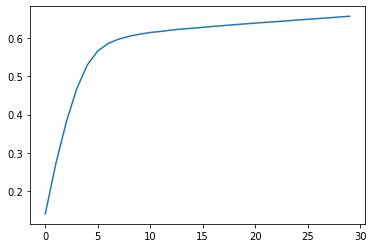

48 [0.998 1.    0.998 0.994] [0.03647432 0.04481717 0.03693943 0.04891785]


Loading required package: lattice
Loading required package: Rcpp
Loading required package: RcppArmadillo
Loading required package: glmnet
Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: horseshoe
Loading required package: pgdraw


epoch: 1 / 30, training rmse: 1.0581, training r2: 0.1425
epoch: 2 / 30, training rmse: 0.976, training r2: 0.2703
epoch: 3 / 30, training rmse: 0.9013, training r2: 0.3778
epoch: 4 / 30, training rmse: 0.8373, training r2: 0.463
epoch: 5 / 30, training rmse: 0.79, training r2: 0.522
epoch: 6 / 30, training rmse: 0.7601, training r2: 0.5574
epoch: 7 / 30, training rmse: 0.7426, training r2: 0.5776
epoch: 8 / 30, training rmse: 0.7328, training r2: 0.5886
epoch: 9 / 30, training rmse: 0.7242, training r2: 0.5983
epoch: 10 / 30, training rmse: 0.7176, training r2: 0.6056
epoch: 11 / 30, training rmse: 0.7123, training r2: 0.6114
epoch: 12 / 30, training rmse: 0.7078, training r2: 0.6162
epoch: 13 / 30, training rmse: 0.7048, training r2: 0.6195
epoch: 14 / 30, training rmse: 0.7011, training r2: 0.6235
epoch: 15 / 30, training rmse: 0.6984, training r2: 0.6264
epoch: 16 / 30, training rmse: 0.6957, training r2: 0.6292
epoch: 17 / 30, training rmse: 0.6941, training r2: 0.631
epoch: 18 / 

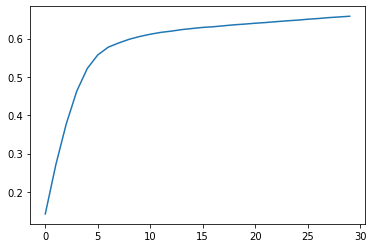

49 [1.    1.    0.998 0.999] [0.03661582 0.04451446 0.03291816 0.05006242]


In [6]:
train_label_1_idx = np.where(train_label == 1)[0]
train_label_2_idx = np.where(train_label == 2)[0]
train_label_3_idx = np.where(train_label == 3)[0]
test_label_1_idx = np.where(test_label == 1)[0]
test_label_2_idx = np.where(test_label == 2)[0]
test_label_3_idx = np.where(test_label == 3)[0]

n = 2000
n_train = 1000
n_test = 1000

num_exp = 50
result_mse = np.zeros((num_exp, 4))
result_acc = np.zeros((num_exp, 4))
L = 50
for exp in range(num_exp):
    random.seed(exp)
    torch.manual_seed(exp)
    np.random.seed(exp)
    #####################################################################
    # generate images
    sign_img, sign = generate_sign(n = n)
    train_sign = sign[0:n_train]
    train_sign_img = sign_img[0:n_train, :]
    test_sign = sign[n_train:n]
    test_sign_img = sign_img[n_train:n, :]
    train_1s = train_img[np.random.choice(train_label_1_idx, size = n_train, replace = False), :]
    train_2s = train_img[np.random.choice(train_label_2_idx, size = n_train, replace = False), :]
    test_1s = test_img[np.random.choice(test_label_1_idx, size = n_train, replace = False), :]
    test_2s = test_img[np.random.choice(test_label_2_idx, size = n_train, replace = False), :]

    train_predictors = np.zeros((n_train, 28*28*3))
    train_outcomes = np.zeros((n_train, 28*28))
    test_predictors = np.zeros((n_test, 28*28*3))
    test_outcomes = np.zeros((n_test, 28*28))
    train_outcomes_label = np.zeros(n_train)
    test_outcomes_label = np.zeros(n_test)
    for i in range(n_train):
        train_1_i = train_1s[i, :].reshape((28, 28))
        train_2_i = train_2s[i, :].reshape((28, 28))
        train_sign_i = train_sign[i]
        train_sign_img_i = train_sign_img[i, :].reshape((28, 28))
        train_predictor_i = np.hstack((train_2_i, train_sign_img_i, train_1_i))
        if train_sign_i == -1:
            label_img_i = train_img[np.random.choice(train_label_1_idx, size = 1, replace = False), :]
            train_outcomes_label[i] = 1
        else:
            label_img_i = train_img[np.random.choice(train_label_3_idx, size = 1, replace = False), :]
            train_outcomes_label[i] = 3
        train_predictors[i, :] = train_predictor_i.reshape(-1)
        train_outcomes[i, :] = label_img_i

    for i in range(n_test):
        test_1_i = test_1s[i, :].reshape((28, 28))
        test_2_i = test_2s[i, :].reshape((28, 28))
        test_sign_i = test_sign[i]
        test_sign_img_i = test_sign_img[i, :].reshape((28, 28))
        test_predictor_i = np.hstack((test_2_i, test_sign_img_i, test_1_i))
        if test_sign_i == -1:
            label_img_i = test_img[np.random.choice(test_label_1_idx, size = 1, replace = False), :]
            test_outcomes_label[i] = 1
        else:
            label_img_i = test_img[np.random.choice(test_label_3_idx, size = 1, replace = False), :]
            test_outcomes_label[i] = 3
        test_predictors[i, :] = test_predictor_i.reshape(-1)
        test_outcomes[i, :] = label_img_i

    np.savetxt("train_predictors.txt", train_predictors)
    np.savetxt("test_predictors.txt", test_predictors)
    np.savetxt("train_outcomes.txt", train_outcomes)
    np.savetxt("test_outcomes.txt", test_outcomes)
    
    #####################################################################
    # train cnn mnist classifier
    cnn = CNN()
    cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)
    cnn_loss = nn.functional.binary_cross_entropy

    cnnX = torch.tensor(train_outcomes, dtype = torch.float32).reshape((n_train, 1, 28, 28))
    cnny = torch.tensor(train_outcomes_label, dtype = torch.float32).reshape((n_train, 1))
    cnny[cnny == 1] = 0
    cnny[cnny == 3] = 1

    cnn_dataset = Dataset(cnnX, cnny)
    cnn_dataloader = torch.utils.data.DataLoader(cnn_dataset, batch_size = 64, shuffle = True)
    
    num_epochs = 100
    cnn.train()
    for epoch in range(num_epochs):
        for (idx, (X_batch, y_batch)) in enumerate(cnn_dataloader):
            output = cnn(X_batch)             
            loss = cnn_loss(output, y_batch)

            # clear gradients for this training step   
            cnn_optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            cnn_optimizer.step()      
            
    #####################################################################
    # fit basis for predictors
    grid_x = np.tile(np.arange(84), 28)
    grid_y = np.repeat(np.arange(28), 84)
    grid_x = (grid_x - 83 / 2) / (83 / 2)
    grid_y = (grid_y - 27 / 2) / (27 / 2)
    grids = np.vstack((grid_x, grid_y))

    X = grids.T
    X = torch.tensor(X, dtype = torch.float32)
    y = train_predictors
    y = torch.tensor(y, dtype = torch.float32)

    model = BFNN(d = 2, L = L, n = n_train, V = 28*28*3)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    mse_criterion = torch.nn.MSELoss()
    for epoch in range(10000):
        yhat = model.forward(X)
        loss = mse_criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    np.savetxt("Psi_predictors.txt", model.Psi.detach().numpy(), delimiter = ",")
    
    #####################################################################
    # fit basis for outcomes
    grid_x = np.tile(np.arange(28), 28)
    grid_y = np.repeat(np.arange(28), 28)
    grid_x = (grid_x - 27 / 2) / (27 / 2)
    grid_y = (grid_y - 27 / 2) / (27 / 2)
    grids = np.vstack((grid_x, grid_y))

    X = grids.T
    X = torch.tensor(X, dtype = torch.float32)
    y = train_outcomes
    y = torch.tensor(y, dtype = torch.float32)
    model = BFNN(d = 2, L = L, n = n_train, V = 28*28)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    mse_criterion = torch.nn.MSELoss()
    for epoch in range(10000):
        optimizer.zero_grad()
        yhat = model.forward(X)
        loss = mse_criterion(yhat, y)
        loss.backward()
        optimizer.step()

    np.savetxt("Psi_outcomes.txt", model.Psi.detach().numpy(), delimiter = ",")
    
    #####################################################################
    # orthogolize basis and find basis coefficients
    subprocess.call(["/sw/arcts/centos7/stacks/gcc/8.2.0/R/4.0.3/bin/Rscript", "part2.R", "{}".format(L)], stdout=subprocess.DEVNULL)
    
    #####################################################################
    # load coefficients and orthogonalized basis
    theta_train_predictors = np.loadtxt("theta_train_predictors.txt")
    theta_test_predictors = np.loadtxt("theta_test_predictors.txt")
    theta_train_outcomes = np.loadtxt("theta_train_outcomes.txt")
    theta_test_outcomes = np.loadtxt("theta_test_outcomes.txt")
    Psi_p = np.loadtxt("Psi_p.txt")
    Psi_o = np.loadtxt("Psi_o.txt")
    
    #####################################################################
    # model relationship of coefficients
    svgd_nn = svgd.svgd_bnn(X_train = theta_train_predictors, 
                        y_train = theta_train_outcomes,
                        a_gamma = 1, 
                        b_gamma = 1, 
                        a_lambda = 1, 
                        b_lambda = 1, 
                        batch_size = 64, 
                        epochs = 30)
    svgd_nn.train()
    
    #####################################################################
    # check prediction accuracy
    theta_train_pred, _, _ = svgd_nn.predict(theta_train_predictors, 0.9)
    theta_test_pred, _, _ = svgd_nn.predict(theta_test_predictors, 0.9)
    train_pred = theta_train_pred @ Psi_o.T
    test_pred = theta_test_pred @ Psi_o.T
    train_pred = torch.tensor(train_pred, dtype = torch.float32).reshape((n_train, 1, 28, 28))
    test_pred = torch.tensor(test_pred, dtype = torch.float32).reshape((n_test, 1, 28, 28))

    result_acc[exp, 0] = sum( (cnn(train_pred).detach().numpy().reshape(-1) > 0.5) == (train_outcomes_label == 3) ) / n_train
    result_acc[exp, 1] = sum( (cnn(test_pred).detach().numpy().reshape(-1) > 0.5) == (test_outcomes_label == 3) ) / n_test

    result_mse[exp, 0] = np.mean((train_pred.detach().numpy().reshape((n_train, 784)) - train_outcomes)**2)
    result_mse[exp, 1] = np.mean((test_pred.detach().numpy().reshape((n_test, 784)) - test_outcomes)**2)
    
    #####################################################################
    # use cnn pipeline to predict outcomes from predictors directly
    cnn_fb = CNN_FB()
    cnn_train_predictors = torch.tensor(train_predictors, dtype = torch.float32).reshape((n_train, 1, 28, 84))
    cnn_train_outcomes = torch.tensor(train_outcomes, dtype = torch.float32).reshape((n_train, 784))
    cnn_fb_loss = nn.functional.mse_loss
    cnn_fb_optim = torch.optim.Adam(cnn_fb.parameters(), lr = 1e-3)

    cnn_fb_dataset = Dataset(cnn_train_predictors, cnn_train_outcomes)
    cnn_fb_dataloader = torch.utils.data.DataLoader(cnn_fb_dataset, batch_size = 64, shuffle = True)

    num_epochs = 100
    cnn.train()
    for epoch in range(num_epochs):
        for (idx, (X_batch, y_batch)) in enumerate(cnn_fb_dataloader):
            output = cnn_fb(X_batch)             
            loss = cnn_fb_loss(output, y_batch)

            cnn_fb_optim .zero_grad()           
            loss.backward()            
            cnn_fb_optim .step()                

    cnn_train_pred = cnn_fb(cnn_train_predictors).reshape((n_train, 1, 28, 28))
    cnn_test_pred = cnn_fb(torch.tensor(test_predictors, dtype = torch.float32).reshape((n_test, 1, 28, 84))).reshape((n_test, 1, 28, 28))

    result_acc[exp, 2] = sum( (cnn(cnn_train_pred).detach().numpy().reshape(-1) > 0.5) == (train_outcomes_label == 3) ) / n_train
    result_acc[exp, 3] = sum( (cnn(cnn_test_pred).detach().numpy().reshape(-1) > 0.5) == (test_outcomes_label == 3) ) / n_test

    result_mse[exp, 2] = np.mean((cnn_train_pred.detach().numpy().reshape((n_train, 784)) - train_outcomes)**2)
    result_mse[exp, 3] = np.mean((cnn_test_pred.detach().numpy().reshape((n_test, 784)) - test_outcomes)**2)
    
    print(exp, result_acc[exp, :], result_mse[exp, :])

np.savetxt("result_mse.txt", result_mse)
np.savetxt("result_acc.txt", result_acc)